In [11]:
import os


!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [12]:

!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge


!mkdir -p ./data/fer2013


!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip -d ./data/fer2013

 92% 261M/285M [00:00<00:00, 1.37GB/s]
100% 285M/285M [00:00<00:00, 1.36GB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: ./data/fer2013/example_submission.csv  
  inflating: ./data/fer2013/fer2013.tar.gz  
  inflating: ./data/fer2013/icml_face_data.csv  
  inflating: ./data/fer2013/test.csv  
  inflating: ./data/fer2013/train.csv  


In [27]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epoch_num = 40
batch_size = 64
learning_rate = 0.0002

In [26]:


transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((48,48)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



full_training_set = torchvision.datasets.FER2013(root='./data', split='train', transform=transform_train)


validation_split = 0.2
num_train = len(full_training_set)
indices = list(range(num_train))
split = int(np.floor(validation_split * num_train))

train_indices, val_indices = indices[split:], indices[:split]

#small set for testing if network works fine
#small_slice = indices[: 125]
from torch.utils.data import Subset
training_set = Subset(full_training_set, train_indices)
validation_set = Subset(full_training_set, val_indices)


testing_set = torchvision.datasets.FER2013(root="./data", split="test", transform=transform_test)


class_count = np.array([3995, 436, 4097, 7215, 4965, 4830, 3171])
weights = 1. / class_count


training_labels = []

for _, label in training_set:
  training_labels.append(label)

sample_weights = np.array([weights[label] for label in training_labels])
sample_weights = torch.from_numpy(sample_weights)

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

training_loader = DataLoader(training_set, batch_size = batch_size, shuffle=False, sampler=sampler)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(testing_set, batch_size=batch_size, shuffle=False)




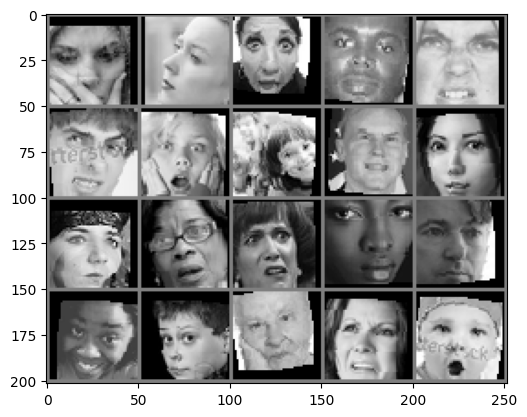

Labels:      4     4     2     6     1     1     4     3     6     6     6     0     1     6     4     3     6     6     1     5


In [ ]:

dataiter = iter(training_loader)
images, labels = next(dataiter) 


def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


img_grid = torchvision.utils.make_grid(images[0:20], nrow=5)
imshow(img_grid)

print('Labels: ', ' '.join('%5s' % labels[j].item() for j in range(20)))

In [29]:
class CNET(nn.Module):
  def __init__(self):
    super().__init__()

    #First block
    self.conv1a = nn.Conv2d(1, 32, 3, padding=1)
    self.bn1a = nn.BatchNorm2d(32)
    self.conv1b = nn.Conv2d(32, 32, 3, padding=1)
    self.bn1b = nn.BatchNorm2d(32)

    # Second block
    self.conv2a = nn.Conv2d(32, 64, 3, padding=1)
    self.bn2a = nn.BatchNorm2d(64)
    self.conv2b = nn.Conv2d(64, 64, 3, padding=1)
    self.bn2b = nn.BatchNorm2d(64)

    # Third block
    self.conv3a = nn.Conv2d(64, 128, 3, padding=1)
    self.bn3a = nn.BatchNorm2d(128)
    self.conv3b = nn.Conv2d(128, 128, 3, padding=1)
    self.bn3b = nn.BatchNorm2d(128)

    # Fourth block
    self.conv4a = nn.Conv2d(128, 256, 3, padding=1)
    self.bn4a = nn.BatchNorm2d(256)
    self.conv4b = nn.Conv2d(256, 256, 3, padding=1)
    self.bn4b = nn.BatchNorm2d(256)


    #Fully connected layer
    self.fc1 = nn.Linear(256 * 3 * 3, 512)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, 256)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(256, 128)
    self.dropout3 = nn.Dropout(0.5)
    self.fc4 = nn.Linear(128, 7)

    self.pool = nn.MaxPool2d(2, 2)




  def forward(self, x):
    #Block 1
    x = F.relu(self.bn1a(self.conv1a(x)))
    x = F.relu(self.bn1b(self.conv1b(x)))
    x = self.pool(x)


    #Block 2
    x = F.relu(self.bn2a(self.conv2a(x)))
    x = F.relu(self.bn2b(self.conv2b(x)))
    x = self.pool(x)

    #Block 3
    x = F.relu(self.bn3a(self.conv3a(x)))
    x = F.relu(self.bn3b(self.conv3b(x)))
    x = self.pool(x)

    #Block 4
    x = F.relu(self.bn4a(self.conv4a(x)))
    x = F.relu(self.bn4b(self.conv4b(x)))
    x= self.pool(x)


    #Fully connected
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.dropout3(x)
    x = self.fc4(x)



    return x


model = CNET().to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epoch_num, eta_min=1e-7)

In [30]:

for epoch in range(epoch_num):

  model.train()
  running_train_loss = 0.0
  train_correct = 0


  for i, (images, labels) in enumerate(training_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    train_correct += (predicted == labels).sum().item()



  scheduler.step()

  # Calculate average training loss and accuracy for the epoch
  epoch_train_loss = running_train_loss / len(training_loader)
  epoch_train_accuracy = 100. * train_correct / len(training_set)



  model.eval()
  running_val_loss = 0.0
  val_correct = 0


  with torch.no_grad():
    for images, labels in validation_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_val_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      val_correct += (predicted == labels).sum().item()


  epoch_val_loss = running_val_loss / len(validation_loader)
  epoch_val_accuracy = 100. * val_correct / len(validation_set)


  current_lr = optimizer.param_groups[0]['lr']
  print(f'Epoch [{epoch+1}/{epoch_num}], '
        f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
        f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%, '
        f'LR: {current_lr:.7f}')



Epoch [1/40], Train Loss: 1.9212, Train Acc: 21.34%, Val Loss: 1.9111, Val Acc: 17.87%, LR: 0.0001997
Epoch [2/40], Train Loss: 1.8453, Train Acc: 26.87%, Val Loss: 1.7986, Val Acc: 24.21%, LR: 0.0001988
Epoch [3/40], Train Loss: 1.7139, Train Acc: 35.32%, Val Loss: 1.7392, Val Acc: 30.62%, LR: 0.0001972
Epoch [4/40], Train Loss: 1.5843, Train Acc: 44.46%, Val Loss: 1.5595, Val Acc: 43.72%, LR: 0.0001951
Epoch [5/40], Train Loss: 1.4936, Train Acc: 49.46%, Val Loss: 1.4790, Val Acc: 47.36%, LR: 0.0001924
Epoch [6/40], Train Loss: 1.4332, Train Acc: 53.02%, Val Loss: 1.4690, Val Acc: 47.69%, LR: 0.0001891
Epoch [7/40], Train Loss: 1.3868, Train Acc: 54.57%, Val Loss: 1.4249, Val Acc: 50.53%, LR: 0.0001853
Epoch [8/40], Train Loss: 1.3543, Train Acc: 56.51%, Val Loss: 1.4414, Val Acc: 49.49%, LR: 0.0001809
Epoch [9/40], Train Loss: 1.3352, Train Acc: 56.93%, Val Loss: 1.3906, Val Acc: 52.80%, LR: 0.0001761
Epoch [10/40], Train Loss: 1.3132, Train Acc: 58.30%, Val Loss: 1.3724, Val Acc: 5

Accuracy of model on testing set is 64.08470325996099


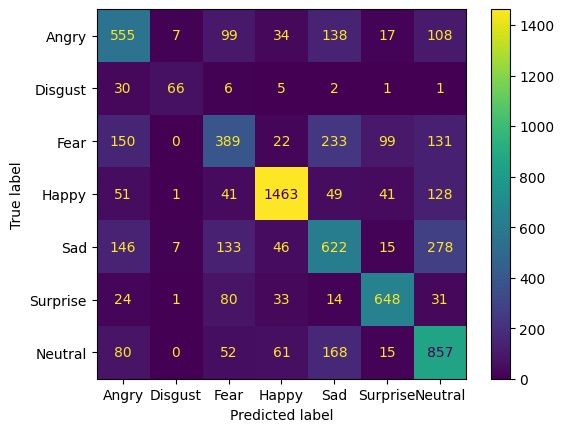

In [32]:

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

all_labels = []
all_predicted = []
model.eval()
with torch.no_grad():
  no_correct = 0
  num_val = len(testing_set) # Using testing set

  for images, labels in testing_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_predicted.extend(predicted.cpu().numpy())

    no_correct += (predicted == labels).sum().item()

  print(f'Accuracy of model on testing set is {no_correct / num_val * 100}')


cm = confusion_matrix(all_labels, all_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [33]:
torch.save(model.state_dict(), "model.pth")
print("Saved model successfully")

Saved model successfully


In [ ]:


model_filename = "model.pth"


torch.save(model.state_dict(), model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to model.pth
